In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


New one

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 0) Load your two splits
df_train = pd.read_excel(
    '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add_spyvix2.xlsx',
    parse_dates=['trading_day','Date']
)
df_val = pd.read_excel(
    '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add_spyvix2.xlsx',
    parse_dates=['trading_day','Date']
)

# 1) Basic preprocessing
for df in (df_train, df_val):
    df.sort_values('trading_day', inplace=True)
    df.dropna(subset=['VIX','Volume','return_t','return_t+1'], inplace=True)

TARGET = 'return_t+1'

# 2) Define your 9 feature-sets
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# 3) Hyper-parameter grid & CV
param_dist = {
    "n_estimators":     [100, 300, 500],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.01, 0.05, 0.1],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}
tscv = TimeSeriesSplit(n_splits=5)

# 4) Storage for results
results = []

# 5) Loop over each “model”
for name, feats in feature_sets.items():
    # slice out X/y
    X_tr, y_tr = df_train[feats], df_train[TARGET]
    X_val, y_val = df_val[feats], df_val[TARGET]

    # RandomizedSearchCV
    base = xgb.XGBRegressor(objective="reg:squarederror",
                            tree_method="hist",
                            random_state=42)
    search = RandomizedSearchCV(base,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=tscv,
                                scoring="neg_mean_squared_error",
                                random_state=42,
                                n_jobs=-1)
    search.fit(X_tr, y_tr)

    best = search.best_estimator_
    bp   = search.best_params_

    # predict on validation
    y_pred = best.predict(X_val)
    res    = y_val - y_pred

    # compute metrics
    mse     = mean_squared_error(y_val, y_pred)
    mae     = mean_absolute_error(y_val, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_val, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_val - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_val)).sum()
    acc     = correct / len(y_val) * 100

    # collect
    results.append({
        'Model': name,
        'Best_params': bp,
        'Val R²': r2,
        'ROOS': roos,
        'Val MSE': mse,
        'Val MAE': mae,
        'Val RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_val)
    })

# 6) Build & display your final table
results_df = pd.DataFrame(results).sort_values('Directional Accuracy (%)', ascending=False)
print(results_df)


                  Model                                        Best_params  \
6       Base+IWSS_Ratio  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
5    Base+IWSS_Impurity  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
4       Base+IWSS_Equal  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
1  Base+Sentiment_score  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
7        Base+IWSS_SHAP  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
8        Base+IWSS_perm  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   
3      Base+IWSS_metric  {'subsample': 0.8, 'n_estimators': 100, 'max_d...   
0                  Base  {'subsample': 0.8, 'n_estimators': 100, 'max_d...   
2         Base+IWSS_PCA  {'subsample': 0.6, 'n_estimators': 100, 'max_d...   

     Val R²      ROOS   Val MSE   Val MAE  Val RMSE  Directional Accuracy (%)  \
6 -0.071768 -0.005999  0.000052  0.005539  0.007229                 54.421769   
5 -0.073390 -0.007522  0.000052  0.005563  0.007234      

In [3]:
results_df

,Model,Best_params,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Directional Accuracy (%),Correct Predictions,Total
6,Base+IWSS_Ratio,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.071768,-0.005999,0.000052,0.005539,0.007229,54.421769,80,147
5,Base+IWSS_Impurity,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.073390,-0.007522,0.000052,0.005563,0.007234,49.659864,73,147
4,Base+IWSS_Equal,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.071818,-0.006047,0.000052,0.005538,0.007229,49.659864,73,147
1,Base+Sentiment_score,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.079494,-0.013251,0.000053,0.005630,0.007255,48.979592,72,147
7,Base+IWSS_SHAP,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.070953,-0.005235,0.000052,0.005547,0.007226,48.299320,71,147
8,Base+IWSS_perm,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.079321,-0.013089,0.000053,0.005563,0.007254,48.299320,71,147
3,Base+IWSS_metric,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.087076,-0.020368,0.000053,0.005577,0.007280,47.619048,70,147
0,Base,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.074915,-0.008953,0.000052,0.005549,0.007240,46.938776,69,147
2,Base+IWSS_PCA,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.070758,-0.005051,0.000052,0.005544,0.007226,46.938776,69,147


In [ ]:
results_bu = results_df
results_bu

,Model,Best_Alpha,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Directional Accuracy (%),Correct Predictions,Total
6,Base+IWSS_Ratio,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.071768,-0.005999,0.000052,0.005539,0.007229,54.421769,80,147
5,Base+IWSS_Impurity,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.073390,-0.007522,0.000052,0.005563,0.007234,49.659864,73,147
4,Base+IWSS_Equal,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.071818,-0.006047,0.000052,0.005538,0.007229,49.659864,73,147
8,Base+IWSS_perm,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.079321,-0.013089,0.000053,0.005563,0.007254,48.299320,71,147
7,Base+IWSS_SHAP,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.070953,-0.005235,0.000052,0.005547,0.007226,48.299320,71,147
3,Base+IWSS_metric,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.087076,-0.020368,0.000053,0.005577,0.007280,47.619048,70,147
0,Base,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.074915,-0.008953,0.000052,0.005549,0.007240,46.938776,69,147
2,Base+IWSS_PCA,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.070758,-0.005051,0.000052,0.005544,0.007226,46.938776,69,147
1,Base+Sentiment_score,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.143798,-0.073609,0.000056,0.005835,0.007468,42.176871,62,147


# Predicting on test set

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# — you already have these loaded —
# df_train = …
# df_val   = …
df_test  = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add_spyvix2.xlsx')
df_test = df_test.dropna(subset=['return_t+1'])

TARGET = 'return_t+1'

# (re-define your nine feature‐sets exactly as before)
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# same hyper‐parameter grid + CV
param_dist = {
    "n_estimators":     [100, 300, 500],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.01, 0.05, 0.1],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}
tscv = TimeSeriesSplit(n_splits=5)

# storage for test results
test_results = []

for name, feats in feature_sets.items():
    # train on your original train split
    X_tr, y_tr = df_train[feats], df_train[TARGET]
    # use the same RandomizedSearchCV you did before to pick best_model
    model = xgb.XGBRegressor(objective="reg:squarederror",
                             tree_method="hist",
                             random_state=42)
    search = RandomizedSearchCV(model,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=tscv,
                                scoring="neg_mean_squared_error",
                                random_state=42,
                                n_jobs=-1)
    search.fit(X_tr, y_tr)
    best = search.best_estimator_

    # now evaluate on test
    X_te, y_te = df_test[feats], df_test[TARGET]
    y_pred = best.predict(X_te)
    res    = y_te - y_pred

    mse     = mean_squared_error(y_te, y_pred)
    mae     = mean_absolute_error(y_te, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_te, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_te - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_te)).sum()
    acc     = correct / len(y_te) * 100

    test_results.append({
        'Model': name,
        'Best_Alpha': search.best_params_,
        'Test R²': r2,
        'Test ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_te)
    })

# build and show your test‐set table
test_df = pd.DataFrame(test_results).sort_values('Directional Accuracy (%)', ascending=False)
test_df

KeyboardInterrupt: 

In [6]:
# with diebold
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

# — you already have these loaded —
# df_train = …
# df_val   = …
df_test  = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add_spyvix2.xlsx')
df_test = df_test.dropna(subset=['return_t+1'])

TARGET = 'return_t+1'

# (re-define your nine feature‐sets exactly as before)
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

best_params_dict = results_df.set_index('Model')['Best_params'].to_dict()

# Evaluate on test set using those best parameters
test_results = []
forecast_errors = {}
xgb_perm_importance_dict = {}

for name, feats in feature_sets.items():
    # Get best hyperparameters for this feature set
    best_params = best_params_dict[name]

    # Create model with those params
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        **best_params
    )

    # Fit on df_train only (or df_train + df_val if you prefer)
    X_tr, y_tr = df_train[feats], df_train[TARGET]
    model.fit(X_tr, y_tr)

    X_te, y_te = df_test[feats], df_test[TARGET]

    # Compute permutation importance on test set
    result = permutation_importance(
        model,
        X_te,
        y_te,
        n_repeats=30,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    importances = pd.Series(result.importances_mean, index=feats)
    xgb_perm_importance_dict[name] = importances

    # Predict on test
    y_pred = model.predict(X_te)
    res    = y_te - y_pred
    forecast_errors[name] = res.values


    # Compute metrics
    mse     = mean_squared_error(y_te, y_pred)
    mae     = mean_absolute_error(y_te, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_te, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_te - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_te)).sum()
    acc     = correct / len(y_te) * 100

    # Collect
    test_results.append({
        'Model': name,
        'Used_Alpha': best_params,
        'Test R²': r2,
        'Test ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_te)
    })

# Final test results DataFrame
test_df = pd.DataFrame(test_results).sort_values('Directional Accuracy (%)', ascending=False)
test_df

,Model,Used_Alpha,Test R²,Test ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
6,Base+IWSS_Ratio,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.021815,-0.008897,0.000074,0.006256,0.008598,51.020408,75,147
7,Base+IWSS_SHAP,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.022703,-0.009773,0.000074,0.006278,0.008602,48.979592,72,147
4,Base+IWSS_Equal,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.010191,0.002580,0.000073,0.006261,0.008549,48.979592,72,147
8,Base+IWSS_perm,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.029738,-0.016720,0.000075,0.006302,0.008631,48.979592,72,147
0,Base,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.017290,-0.004429,0.000074,0.006244,0.008579,46.938776,69,147
2,Base+IWSS_PCA,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.029455,-0.016441,0.000074,0.006315,0.008630,46.258503,68,147
5,Base+IWSS_Impurity,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.023738,-0.010796,0.000074,0.006284,0.008606,44.897959,66,147
1,Base+Sentiment_score,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",-0.029999,-0.016978,0.000075,0.006396,0.008633,44.217687,65,147
3,Base+IWSS_metric,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",-0.024218,-0.011269,0.000074,0.006305,0.008608,42.176871,62,147


## Feature importance

In [ ]:
xgb_perm_df = pd.DataFrame(xgb_perm_importance_dict).T
xgb_perm_df

,IWSS_Equal,IWSS_Impurity,IWSS_PCA,IWSS_Ratio,IWSS_SHAP,IWSS_metric,IWSS_perm,Sentiment_score,VIX,Volume,return_t
Base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.303719e-07,1.234969e-07,-2.818491e-07
Base+Sentiment_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.128947e-07,5.913084e-07,6.853546e-08,5.754749e-07
Base+IWSS_PCA,NaN,NaN,-6.859958e-07,NaN,NaN,NaN,NaN,NaN,4.076589e-07,8.800059e-07,-9.027112e-07
Base+IWSS_metric,NaN,NaN,NaN,NaN,NaN,-0.000001,NaN,NaN,2.485550e-07,1.346882e-07,2.267419e-07
Base+IWSS_Equal,6.489737e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.293704e-07,9.100729e-07,-8.442790e-07
Base+IWSS_Impurity,NaN,2.036368e-09,NaN,NaN,NaN,NaN,NaN,NaN,4.946027e-07,7.823637e-07,-1.014054e-06
Base+IWSS_Ratio,NaN,NaN,NaN,-3.473425e-08,NaN,NaN,NaN,NaN,4.668940e-07,5.795027e-07,-6.108669e-07
Base+IWSS_SHAP,NaN,NaN,NaN,NaN,1.143124e-07,NaN,NaN,NaN,5.298681e-07,1.086444e-06,-1.172931e-06
Base+IWSS_perm,NaN,NaN,NaN,NaN,NaN,NaN,-5.926770e-07,NaN,5.812269e-07,8.152891e-07,-1.025634e-06


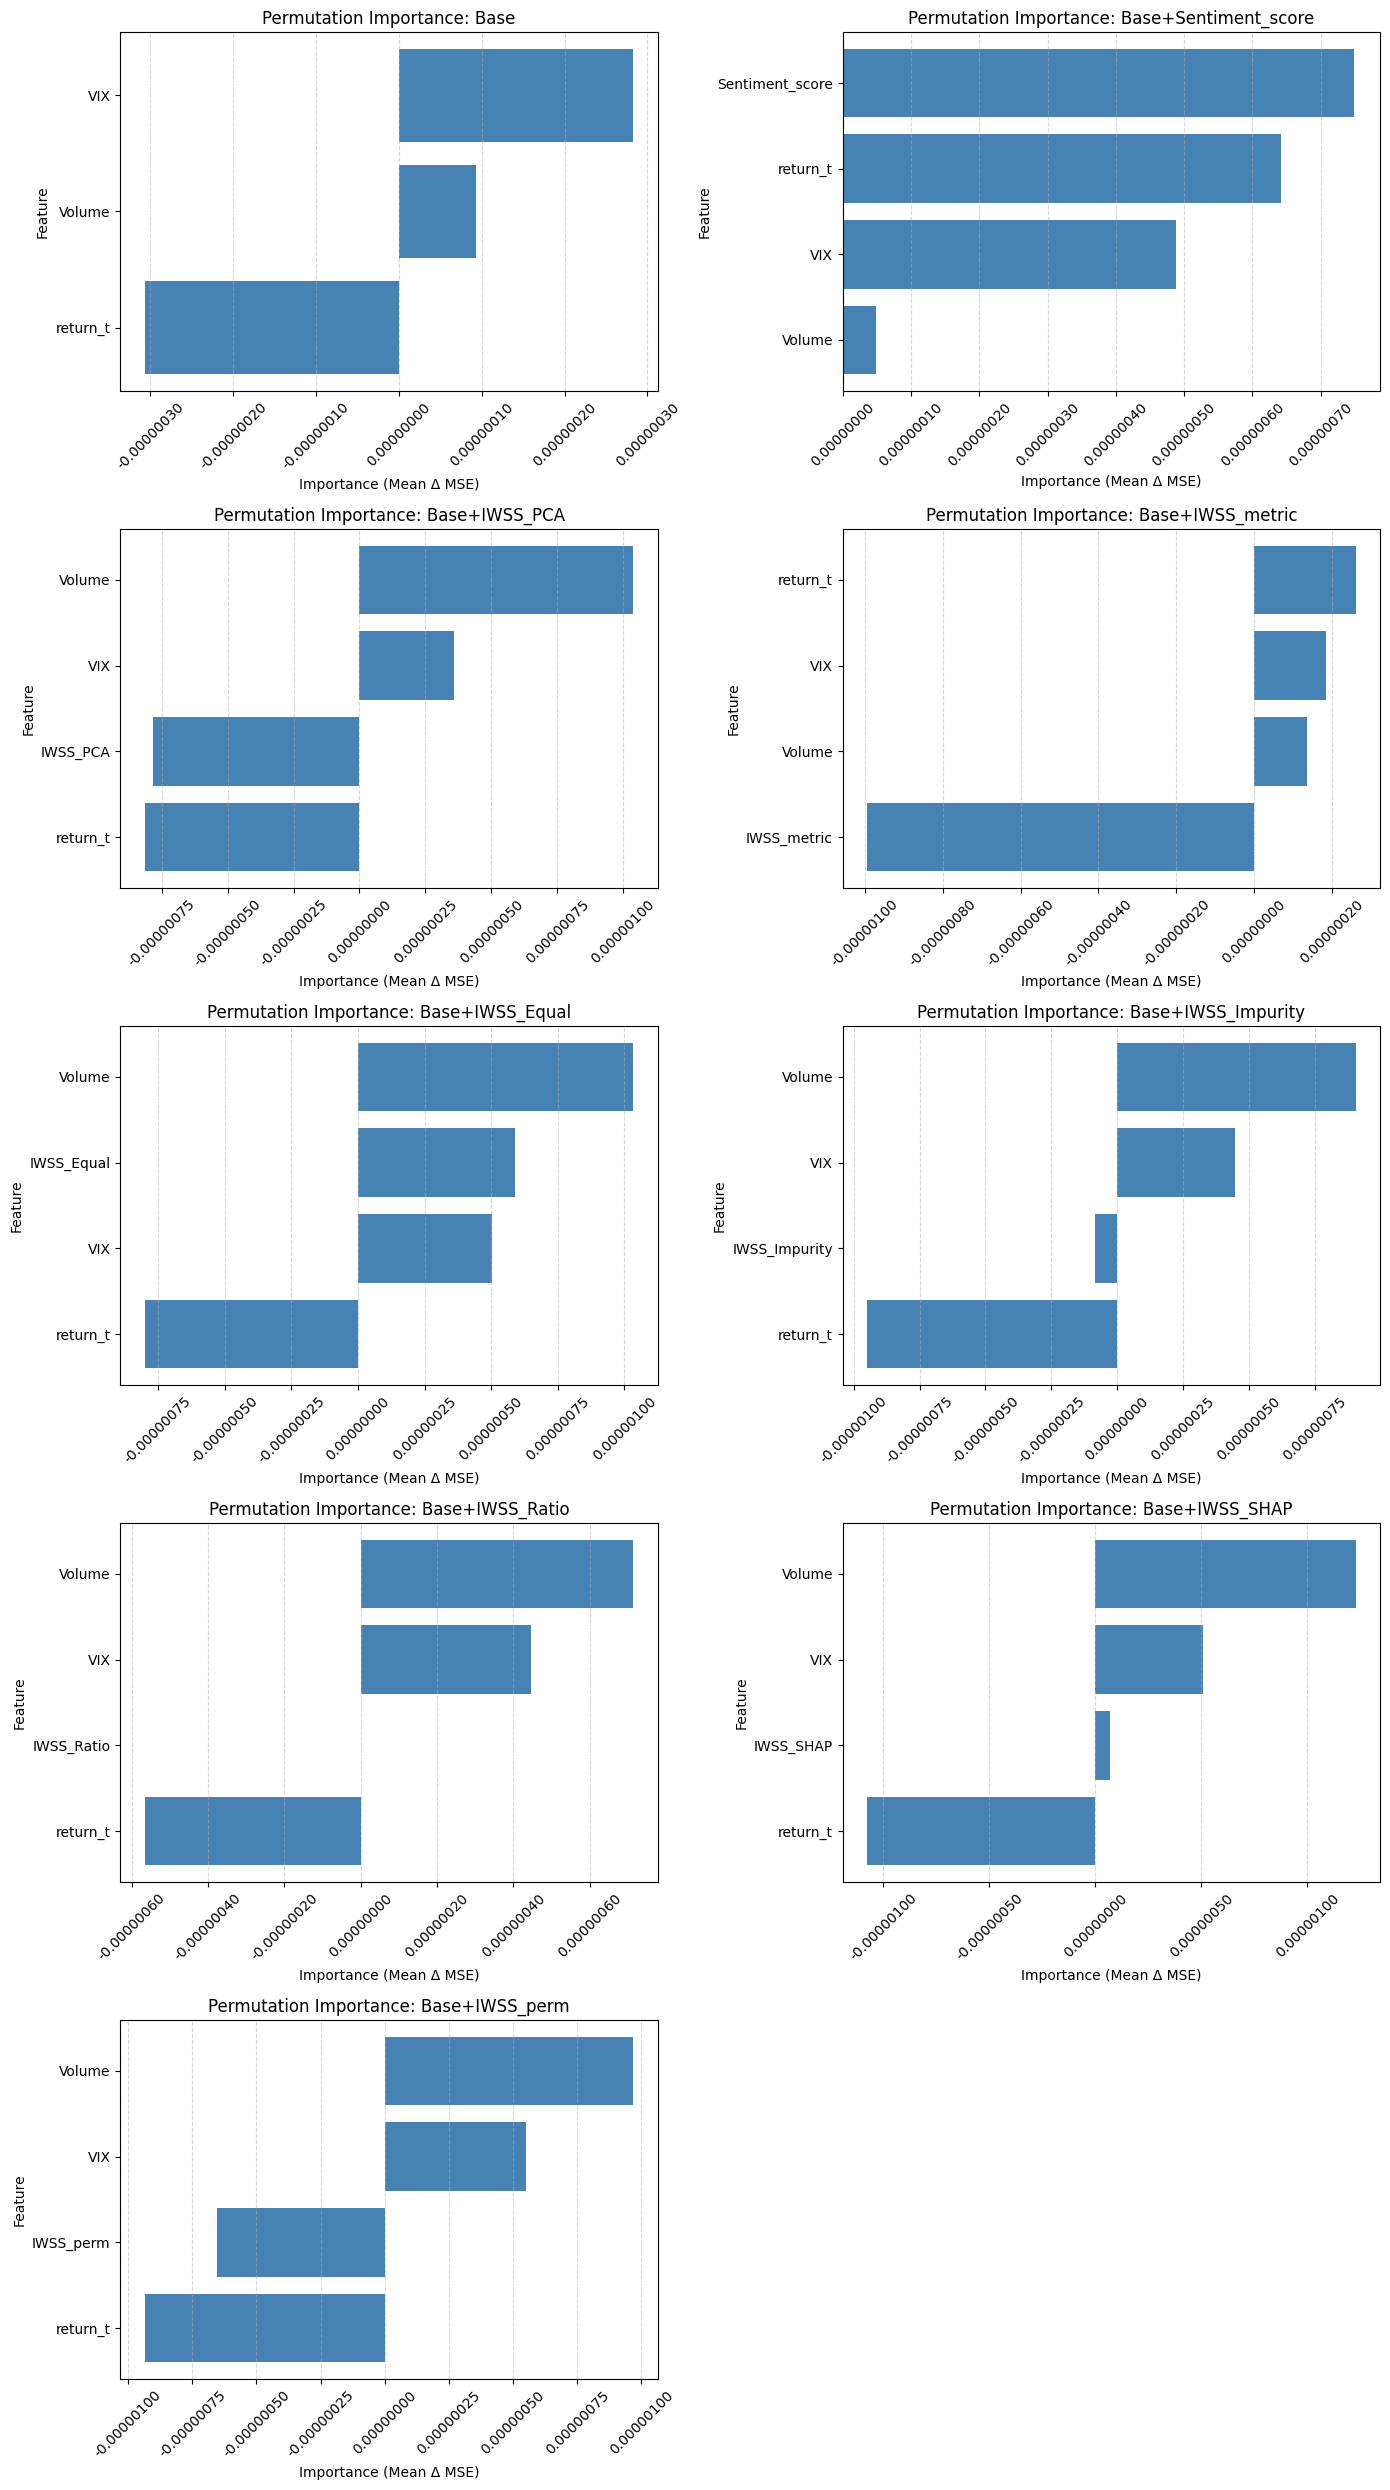

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(xgb_perm_importance_dict)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(xgb_perm_importance_dict.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

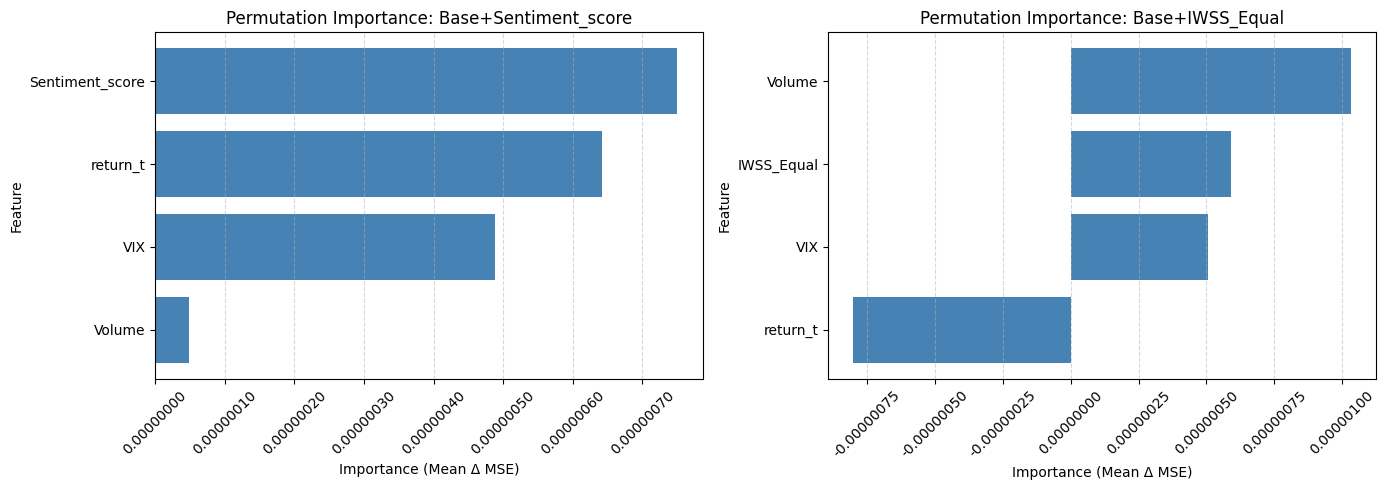

In [ ]:
filtered_importance = {
    name: imp for name, imp in xgb_perm_importance_dict.items()
    if 'Sentiment_score' in name or 'IWSS_Equal' in name
}

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(filtered_importance)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(filtered_importance.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Diebold Mariano

In [ ]:
from scipy import stats

# Diebold-Mariano test function
def diebold_mariano_test(e1, e2, crit='MSE'):
    e1, e2 = np.asarray(e1), np.asarray(e2)
    if crit in ['MSE', 'RMSE']:
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE', 'RMSE', or 'MAE'")
    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)
    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n-1))
    return dm_stat, p_value

In [ ]:
# Extract only IWSS-based models from forecast_errors
iwss_models = [name for name in forecast_errors if 'IWSS' in name]

# --- Compare each IWSS against Sentiment_score ---
sentiment_errors = forecast_errors['Base+Sentiment_score']
dm_results = []

for model_name in iwss_models:
    errors = forecast_errors[model_name]
    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs. Base+Sentiment_score',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better',
        'Significant': p_value < 0.05
    })

# --- Compare each IWSS against Base ---
base_errors = forecast_errors['Base']

for model_name in iwss_models:
    errors = forecast_errors[model_name]
    dm_stat, p_value = diebold_mariano_test(errors, base_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs. Base',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Base better' if dm_stat > 0 else 'IWSS better',
        'Significant': p_value < 0.05
    })

# --- All pairwise IWSS comparisons ---
for i, model_a in enumerate(iwss_models):
    for model_b in iwss_models[i + 1:]:
        e1 = forecast_errors[model_a]
        e2 = forecast_errors[model_b]
        dm_stat, p_value = diebold_mariano_test(e1, e2, crit='MSE')
        interpretation = f'{model_a} better' if dm_stat > 0 else f'{model_b} better'
        dm_results.append({
            'Comparison': f'{model_a} vs. {model_b}',
            'DM Statistic': dm_stat,
            'p-value': p_value,
            'Interpretation': interpretation,
            'Significant': p_value < 0.05
        })

# Convert to DataFrame and sort
dm_df = pd.DataFrame(dm_results)


In [ ]:
dm_df

,Comparison,DM Statistic,p-value,Interpretation,Significant
0,Base+IWSS_PCA vs. Base+Sentiment_score,-0.469148,0.639664,IWSS better,False
1,Base+IWSS_metric vs. Base+Sentiment_score,-0.942474,0.347507,IWSS better,False
2,Base+IWSS_Equal vs. Base+Sentiment_score,-1.358226,0.176487,IWSS better,False
3,Base+IWSS_Impurity vs. Base+Sentiment_score,-0.829265,0.408308,IWSS better,False
4,Base+IWSS_Ratio vs. Base+Sentiment_score,-0.873078,0.384054,IWSS better,False
5,Base+IWSS_SHAP vs. Base+Sentiment_score,-0.826495,0.409872,IWSS better,False
6,Base+IWSS_perm vs. Base+Sentiment_score,-0.496193,0.620505,IWSS better,False
7,Base+IWSS_PCA vs. Base,0.658100,0.511510,Base better,False
8,Base+IWSS_metric vs. Base,0.605072,0.546070,Base better,False
9,Base+IWSS_Equal vs. Base,-0.467102,0.641123,IWSS better,False
